**DATA DESCRIPTION:**

<p>This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an
occurrence of an accident.</p>


**Columns description:**

‣ **Data**: timestamp or time/date information

‣ **Countries**: which country the accident occurred (anonymised)

‣ **Local**: the city where the manufacturing plant is located (anonymised)

‣ **Industry sector**: which sector the plant belongs to

‣ Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)

‣ **Potential Accident Level**: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors
involved in the accident)

‣ **Genre**: if the person is male of female

‣ **Employee or Third Party**: if the injured person is an employee or a third party

‣ **Critical Risk**: some description of the risk involved in the accident

‣ **Description**: Detailed description of how the accident happened.

In [1]:
import re
import string
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [2]:
if not nltk:
  !pip install nltk

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

In [5]:
def mount_drive(fpath):
  try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_path = f"{google_drive_prefix}/{fpath}"
    print(data_path)
    return data_path
  except ModuleNotFoundError:
    data_prefix = f"{fpath}"

In [6]:
def verify_sample_data(df,records):
  if not(records):
    records = 5
  print(f"verifying first {records} records and last {records} records")

In [7]:
def get_percentage_of_missing_values(df):
  print("Checking for missing values and print percentage for each attribute\n")
  result = (round(df.isnull().sum() / (df.isnull().count())*100))
  print(f"missing value percentage {result}\n")
  return result

In [8]:
def load_and_verify_data(file_path):

    try:
        file_path = mount_drive(file_path)
        data = pd.read_excel(file_path)
        print(f"Rows = {data.shape[0]} and Columns = {data.shape[1]} in the DataFrame\n")
        print(f"{data.info()}\n")
        print(f"{data.describe()}\n")
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

In [9]:
def clean_data(df, columns_name_mapping):

    if "Unnamed: 0" in df.columns:
        df.drop("Unnamed: 0", axis=1, inplace=True)
        print("Unnamed: 0 column dropped\n")

    df.rename(columns=columns_name_mapping, inplace=True)

    get_percentage_of_missing_values(df)

    print(f"Duplicate rows sum is: {df.duplicated().sum()} rows\n")
    print("Printing duplicate rows:\n")
    duplicateDF = df[df.duplicated()]
    dup_records = duplicateDF.to_json(orient='records')
    for rec in dup_records.split(','):
        print(rec)

    print("Removing duplicate rows\n")
    df.drop_duplicates(inplace=True)

    print(f"Rows = {df.shape[0]} and Columns = {df.shape[1]} in the DataFrame")
    return df

In [10]:

def plot_distribution(data,variable_name):

  target_variable = data[variable_name]
  plt.hist(target_variable)
  plt.xlabel(f"{variable_name}")
  plt.ylabel("Frequency")
  plt.title("Distribution of Target Variable")
  plt.show()

In [11]:
def plot_tring_accuracy(history,t_lebel,v_level,y_level):

  plt.figure(figsize=(5, 3))
  plt.plot(history.history['accuracy'], color='b', label=t_lebel)
  plt.plot(history.history['val_accuracy'], color='r', label=v_level)
  plt.title(f"{t_lebel} and {v_level}")
  plt.xlabel('Epoch')
  plt.ylabel(y_level)
  plt.legend()
  plt.show()

In [12]:
def identify_outliers(df, column, threshold=1.5):


    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    print(f"Q1: {q1}\n")
    print(f"Q3: {q3}\n")
    print(f"IQR: {iqr}\n")
    print(f"Lower Bound: {lower_bound}\n")
    print(f"Upper Bound: {upper_bound}\n")

    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [13]:
def get_outliers_details(df):
  for col in df.columns:
    print(f"Outliers for {col}\n")
    if col != 'Description':
      outliers = identify_outliers(df, col, threshold=1.5)
      #print (outliers)

In [14]:
#configs
file_path = "dataset/Data+Set+-+industrial_safety_and_health_database_with_accidents_description.xlsx"

columns_name_mapping ={'Data':'ReportDate',
                      'Countries':'Country',
                      'Genre':'Gender',
                      'Employee or Third Party':'EmployeeType',
                      'Critical Risk':'CriticalRisk'}


# Configure models dictionary
model_config = {
        "LogisticRegression": LogisticRegression(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "SVM": SVC()
    }

#Hyper Parameter
param_grids = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }
  }


# Define the base models
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC())
]

In [15]:
def visualize_dataframe(df):



  # Get descriptive statistics
  descriptive_stats = df.describe()
  print(f"\nDescriptive statistics:\n{descriptive_stats}")

  # Plot distribution of numerical columns
  numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
  if numerical_cols.size > 0:  # Check if there are any numerical columns
    for col in numerical_cols:
        print(f"Plot distribution of numerical columns: {col}")
        plt.hist(df[col])
        plt.title(f"Distribution of {col}")
        plt.show()
  else:
    print("No numerical columns found for plotting distributions.")

  # Plot bar chart of categorical columns
  for col in df.select_dtypes(include=["object", "category"]):
    print(f"Plot bar chart of categorical columns: {col}")
    counts = df[col].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title(f"Count of values in {col}")
    plt.show()

  # Calculate and plot correlations for numerical columns only if they exist
  if numerical_cols.size > 0:
    correlations = df[numerical_cols].corr()  # Calculate correlations only if numerical columns exist
    sns.heatmap(correlations, annot=True)
    plt.title("Correlation matrix")
    plt.show()
  else:
    print("No numerical columns found for correlation analysis.")

  # Analyze outliers
  for col in df.select_dtypes(include=["int64", "float64"]):
    outliers = identify_outliers(df, col)
    print(f"Outliers for {col}:\n{outliers}")

In [16]:

def preprocess_text(df):


    print("Remove punctuation")
    df['Description'] = df['Description'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x)) # Convert the column to string type

    print("Convert text to lowercase")
    df['Description'] = df['Description'].apply(lambda x: x.lower())

    print("Remove stop words")
    stopwords = nltk.corpus.stopwords.words('english')
    df['Description'] = df['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    print("Tokenize the text")
    df['Description'] = df['Description'].apply(nltk.word_tokenize)

    print("Lemmatize the tokens")
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['Description'] = df['Description'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return df

**Data Ingestion**

In [17]:
data = load_and_verify_data(file_path)

Mounted at /content/drive/
/content/drive/My Drive/dataset/Data+Set+-+industrial_safety_and_health_database_with_accidents_description.xlsx
Rows = 425 and Columns = 11 in the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk         

In [18]:
df = data.copy()

In [19]:
verify_sample_data(data, 5)

verifying first 5 records and last 5 records


#***Data Summary***

1. **Data and Context**:
   - The dataset contains information related to accidents.
   - Columns include details like date, location, industry sector, accident level, potential accident level, genre, and critical risk.

2. **Key Findings**:
   - The accidents occurred across different countries and localities.
   - Various industry sectors were affected.
   - The severity of accidents ranged from minor to potentially catastrophic.
   - Both employees and third parties were involved.
   - Critical risks were identified.

3. **Limitations**:
   - Further analysis would require examining specific incidents and patterns.


**Data Cleaning**

In [20]:
df = clean_data(df, columns_name_mapping)

Unnamed: 0 column dropped

Checking for missing values and print percentage for each attribute

missing value percentage ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64

Duplicate rows sum is: 7 rows

Printing duplicate rows:

[{"ReportDate":1459468800000
"Country":"Country_01"
"Local":"Local_01"
"Industry Sector":"Mining"
"Accident Level":"I"
"Potential Accident Level":"V"
"Gender":"Male"
"EmployeeType":"Third Party (Remote)"
"CriticalRisk":"Others"
"Description":"In circumstances that two workers of the Abratech company were doing putty work inside the conditioning tank (5 meters deep and covered by platforms) of metal gratings - grating- in the upper part)
 two other employees of the HyT company carri

In [21]:
print("Displaying Clean data\n")
verify_sample_data(df,5)

Displaying Clean data

verifying first 5 records and last 5 records


checking unique value

In [22]:
df.nunique(axis=0)

ReportDate                  287
Country                       3
Local                        12
Industry Sector               3
Accident Level                5
Potential Accident Level      6
Gender                        2
EmployeeType                  3
CriticalRisk                 33
Description                 411
dtype: int64

Out of 411 records:

- **ReportDate**: 287 unique values.
- **Country**: 3 unique values.
- **Local**: 12 unique values.
- **Industry Sector**: 3 unique values.
- **Accident Level**: 5 unique values.
- **Potential Accident Level**: 6 unique values.
- **Gender**: 2 unique values.
- **EmployeeType**: 3 unique values.
- **CriticalRisk**: 33 unique values.
- **Description**: 411 unique values.

Chicking missing values

In [23]:
get_percentage_of_missing_values(df)

Checking for missing values and print percentage for each attribute

missing value percentage ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64



ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64

There is no missing value.

In [24]:
df['ReportDate'] = pd.to_datetime(df['ReportDate'], format='%Y/%m/%d')
df['Accident Level'] = df['Accident Level'].astype('category')
df['Potential Accident Level'] = df['Potential Accident Level'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Local'] = df['Local'].astype('category')
df['Industry Sector'] = df['Industry Sector'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['EmployeeType'] = df['EmployeeType'].astype('category')
df['CriticalRisk'] = df['CriticalRisk'].astype('category')

df['ReportDate'] = pd.to_datetime(df['ReportDate'])
df['Year'] = df.ReportDate.apply(lambda x : x.year)
df['Month'] = df.ReportDate.apply(lambda x : x.month)
df['Day'] = df.ReportDate.apply(lambda x : x.day)


df.head()


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ReportDate                418 non-null    datetime64[ns]
 1   Country                   418 non-null    category      
 2   Local                     418 non-null    category      
 3   Industry Sector           418 non-null    category      
 4   Accident Level            418 non-null    category      
 5   Potential Accident Level  418 non-null    category      
 6   Gender                    418 non-null    category      
 7   EmployeeType              418 non-null    category      
 8   CriticalRisk              418 non-null    category      
 9   Description               418 non-null    object        
 10  Year                      418 non-null    int64         
 11  Month                     418 non-null    int64         
 12  Day                       4

,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10


# EDA


Descriptive statistics:
                          ReportDate         Year       Month         Day
count                            418   418.000000  418.000000  418.000000
mean   2016-09-18 20:50:31.578947328  2016.322967    5.267943   15.076555
min              2016-01-01 00:00:00  2016.000000    1.000000    1.000000
25%              2016-04-30 06:00:00  2016.000000    3.000000    8.000000
50%              2016-09-06 00:00:00  2016.000000    5.000000   15.000000
75%              2017-02-06 12:00:00  2017.000000    7.000000   22.000000
max              2017-07-09 00:00:00  2017.000000   12.000000   31.000000
std                              NaN     0.468170    3.186449    8.618416
Plot distribution of numerical columns: Year


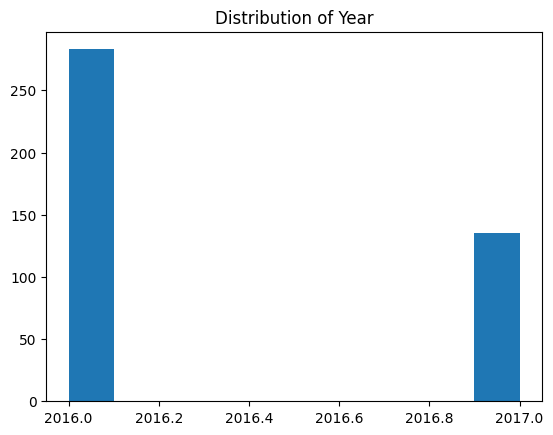

Plot distribution of numerical columns: Month


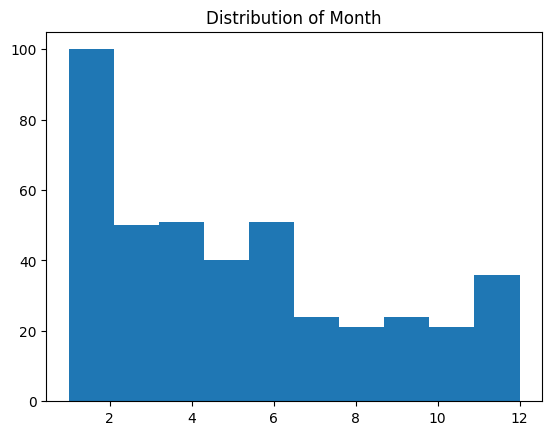

Plot distribution of numerical columns: Day


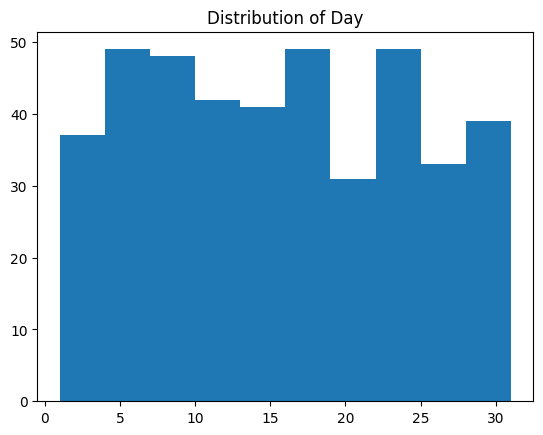

Plot bar chart of categorical columns: Country


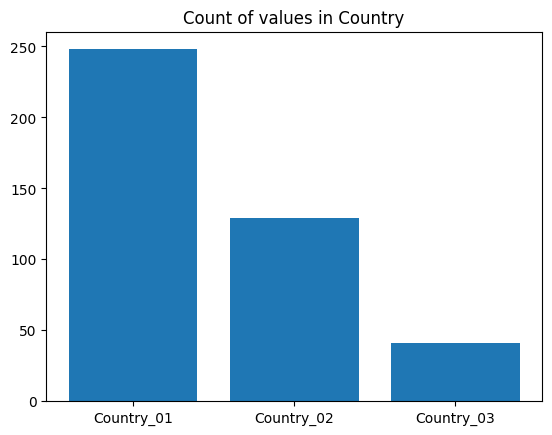

Plot bar chart of categorical columns: Local


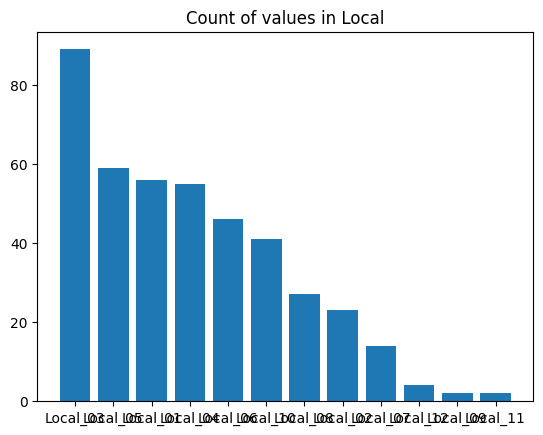

Plot bar chart of categorical columns: Industry Sector


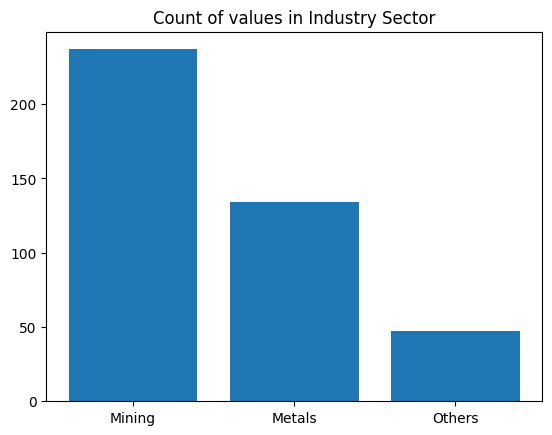

Plot bar chart of categorical columns: Accident Level


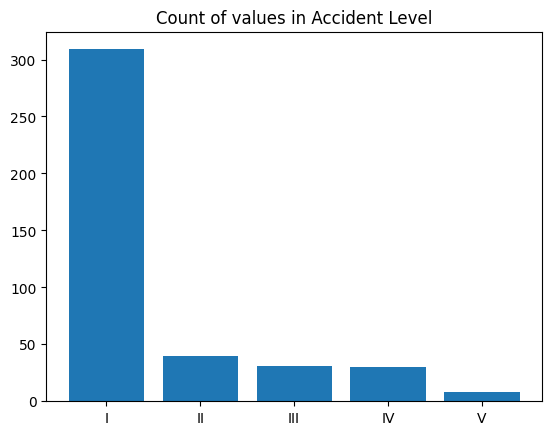

Plot bar chart of categorical columns: Potential Accident Level


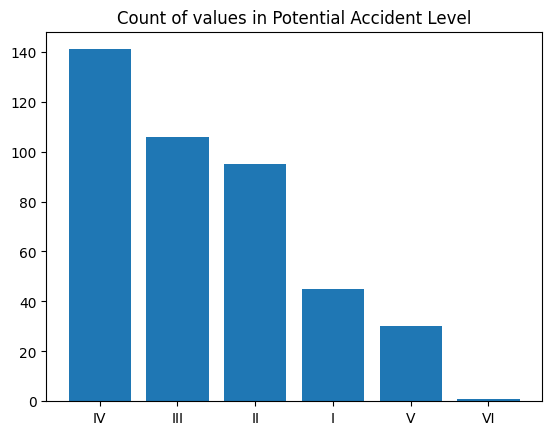

Plot bar chart of categorical columns: Gender


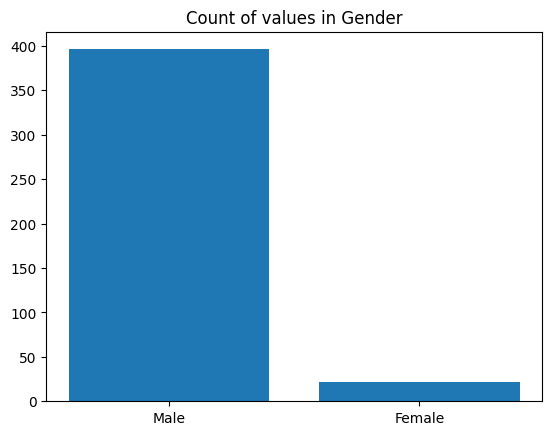

Plot bar chart of categorical columns: EmployeeType


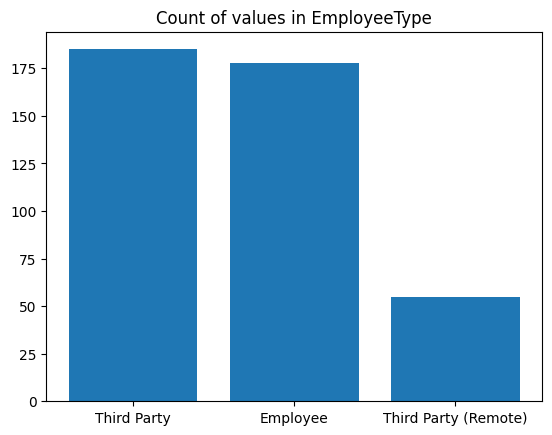

Plot bar chart of categorical columns: CriticalRisk


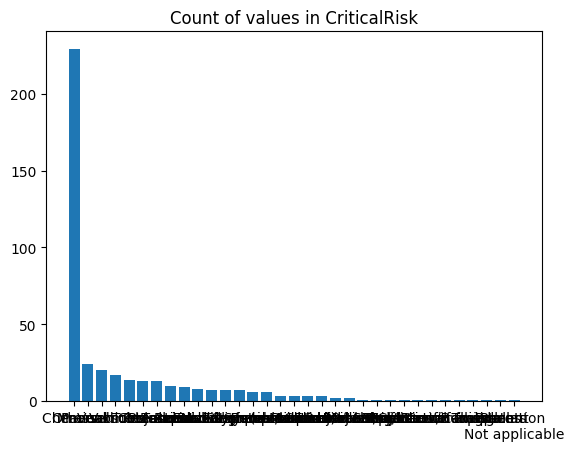

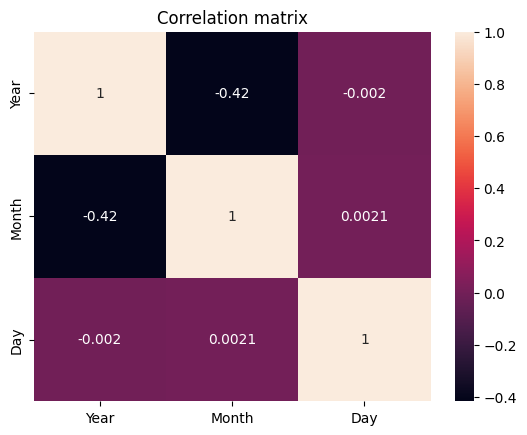

Q1: 2016.0

Q3: 2017.0

IQR: 1.0

Lower Bound: 2014.5

Upper Bound: 2018.5

Outliers for Year:
0      False
1      False
2      False
3      False
4      False
       ...  
420    False
421    False
422    False
423    False
424    False
Name: Year, Length: 418, dtype: bool
Q1: 3.0

Q3: 7.0

IQR: 4.0

Lower Bound: -3.0

Upper Bound: 13.0

Outliers for Month:
0      False
1      False
2      False
3      False
4      False
       ...  
420    False
421    False
422    False
423    False
424    False
Name: Month, Length: 418, dtype: bool
Q1: 8.0

Q3: 22.0

IQR: 14.0

Lower Bound: -13.0

Upper Bound: 43.0

Outliers for Day:
0      False
1      False
2      False
3      False
4      False
       ...  
420    False
421    False
422    False
423    False
424    False
Name: Day, Length: 418, dtype: bool


In [25]:
edaDf = df.drop(columns=['Description'])
visualize_dataframe(edaDf)

In [26]:
import altair as alt

# Create a new column for the season based on the month
df['Season'] = pd.to_datetime(df['ReportDate']).dt.month.apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Group the data by season and count the number of accidents in each season
season_counts = df.groupby('Season')['ReportDate'].count().reset_index(name='Count')

# Create the FW plot
season_counts = alt.Chart(season_counts).mark_line().encode(
    x='Season',
    y='Count'
)

chart = alt.Chart(df).mark_bar().encode(x='Industry Sector', y='count()')

alt.vconcat(season_counts, chart)

alt.VConcatChart(...)

In [27]:
df = preprocess_text(df)
df.head()

Remove punctuation
Convert text to lowercase
Remove stop words
Tokenize the text
Lemmatize the tokens


,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day,Season
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"[removing, drill, rod, jumbo, 08, maintenance,...",2016,1,1,Winter
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"[activation, sodium, sulphide, pump, piping, u...",2016,1,2,Winter
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"[substation, milpo, located, level, 170, colla...",2016,1,6,Winter
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"[945, approximately, nv, 1880, cx695, ob7, per...",2016,1,8,Winter
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"[approximately, 1145, circumstance, mechanic, ...",2016,1,10,Winter


In [28]:
def preprocess_data(df):
    # Vectorize 'Description'
    vectorizer = TfidfVectorizer()
    if df['Description'].apply(type).eq(list).any():
        df['Description'] = df['Description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    X_text = vectorizer.fit_transform(df['Description'])
    # One-hot encode categorical features
    category_cols = [col for col in df.select_dtypes(include=["object", "category"])]
    X_categorical = pd.get_dummies(df[category_cols])
    # Combine features
    X = np.hstack((X_text.toarray(), X_categorical.values))
    y = df['Accident Level']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [29]:
def apply_smote(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

In [30]:
def feature_engineering(df):
    # Create new features based on existing ones
    df['Accident_Severity'] = df['Accident Level'].apply(lambda x: 1 if x in ['I', 'II'] else 2 if x in ['III', 'IV'] else 3)
    df['Industry_Risk'] = df['Industry Sector'].apply(lambda x: 'High' if x == 'Chemical' else 'Medium' if x == 'Oil and Gas' else 'Low')
    df['Employee_Exposure'] = df['EmployeeType'].apply(lambda x: 'High' if x == 'Employee' else 'Low' if x == 'Third Party' else 'Medium')
    return df

In [31]:
def train_ensemble_model(estimators, X_train, y_train, X_test, y_test):
    """
    Trains an ensemble model using the given estimators.

    Args:
        estimators (list of tuples): List of (name, model) pairs.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.

    Returns:
        float: Accuracy of the ensemble model.
        str: Classification report.
    """
    ensemble = VotingClassifier(estimators)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, classification_report(y_test, y_pred)

In [32]:
def train_and_evaluate_models_hyper_params(model_config, param_grids, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates machine learning models using grid search or random search.

    Args:
        model_config (dict): Dictionary containing model names as keys and model instances as values.
        param_grids (dict): Dictionary containing model names as keys and hyperparameter grids as values.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.

    Returns:
        dict: A dictionary containing best parameters and scores for each model.
    """
    results = {}

    for model_name, param_grid in param_grids.items():
        model = model_config[model_name]

        # Choose the appropriate search method
        search_method = GridSearchCV if model_name != 'SVM' else RandomizedSearchCV

        search = search_method(model, param_grid, cv=5)
        search.fit(X_train, y_train)

        # Store the best parameters and score
        results[model_name] = {
            'best_params': search.best_params_,
            'best_score': search.best_score_
        }

        # Evaluate on test data
        y_pred = search.predict(X_test)
        print(f"\n--- {model_name} ---")
        print("Best parameters:", search.best_params_)
        print("Best score:", search.best_score_)
        print("Classification Report:\n", classification_report(y_test, y_pred))

    return results

In [33]:
import numpy as np
from sklearn.metrics import classification_report

def calculate_total_cost(y_true, y_pred, class_impact):
    """
    Calculates the total cost of misclassification based on a cost matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.

    Returns:
        float: Total cost of misclassification.
    """
    class_labels = list(class_impact.keys())
    cost_matrix = np.zeros((len(class_impact), len(class_impact)))

    for i, true_class in enumerate(class_impact):
        for j, pred_class in enumerate(class_impact):
            if true_class != pred_class:
                cost_matrix[i, j] = 1

    total_cost = 0
    for i, true_class in enumerate(y_true):
        pred_class = y_pred[i]
        total_cost += cost_matrix[class_labels.index(true_class), class_labels.index(pred_class)]

    return total_cost

def prioritize_high_impact_classes(y_true, y_pred, class_impact, high_impact_classes):
    """
    Prioritizes improving performance for high-impact classes.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.
        high_impact_classes (list): List of high-impact class labels.

    Returns:
        None
    """
    for c in high_impact_classes:
        misclassified_indices = y_true[(y_true == c) & (y_pred != c)].index.tolist()
        print(f"Misclassified indices for class {c}: {misclassified_indices}")


In [34]:
fdf = feature_engineering(df=df.copy())

In [35]:
X_train, X_test, y_train, y_test = preprocess_data(df)
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
fX_train, fX_test, fy_train, fy_test = preprocess_data(fdf)


params = {
    "without sampling or future enginering":[X_train, X_test, y_train, y_test],
    "with Smote":[X_train_resampled, X_test, y_train_resampled, y_test],
    "with feature_engineering":[fX_train, fX_test, fy_train, fy_test]
}

In [36]:
def calculate_total_cost(y_true, y_pred, class_impact):
    """
    Calculates the total cost of misclassification based on a cost matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.

    Returns:
        float: Total cost of misclassification.
    """
    class_labels = list(class_impact.keys())
    cost_matrix = np.zeros((len(class_impact), len(class_impact)))

    for i, true_class in enumerate(class_impact):
        for j, pred_class in enumerate(class_impact):
            if true_class != pred_class:
                cost_matrix[i, j] = 1

    total_cost = 0
    for i, true_class in enumerate(y_true):
        pred_class = y_pred[i]
        total_cost += cost_matrix[class_labels.index(true_class), class_labels.index(pred_class)]

    return total_cost

def prioritize_high_impact_classes(y_true, y_pred, class_impact, high_impact_classes):
    """
    Prioritizes improving performance for high-impact classes.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.
        high_impact_classes (list): List of high-impact class labels.

    Returns:
        None
    """
    for c in high_impact_classes:
        misclassified_indices = y_true[(y_true == c) & (y_pred != c)].index.tolist()
        print(f"Misclassified indices for class {c}: {misclassified_indices}")

def train_and_evaluate_models(model_config,args):
    """

    Args:
      model_config: model configuration
      args: parameters
    """

    # Defining class impact
    class_impact = {
    "I": 1,  # Low impact
    "II": 2,  # Medium impact
    "III": 3,  # High impact
    "IV": 4,  # Severe impact
    "V": 5,  # Catastrophic impact
    }

    # Train and evaluate models with different params
    for name, model in model_config.items():
      print(f"\n--- {name} ---")
      for param_name,args in params.items():

        print(f"\n train and test model parameter {param_name} ---")
        X_train, X_test, y_train, y_test = args

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))

        # Calculate total cost of misclassification
        total_cost = calculate_total_cost(y_test, y_pred, class_impact)
        print(f"Total cost of misclassification: {total_cost}")

        # Prioritize improving performance for high-impact classes
        high_impact_classes = ["III", "IV", "V"]
        prioritize_high_impact_classes(y_test, y_pred, class_impact, high_impact_classes)

        # Generate the confusion matrix
        confusion_matrix_result = confusion_matrix(y_test, y_pred) # Assign result to variable
        # Print the confusion matrix
        print("Confusion Matrix:\n", confusion_matrix_result)

In [37]:
train_and_evaluate_models(model_config=model_config,args=params)


--- LogisticRegression ---

 train and test model parameter without sampling or future enginering ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           I       1.00      1.00      1.00        63
          II       1.00      1.00      1.00         8
         III       1.00      1.00      1.00         4
          IV       1.00      1.00      1.00         7
           V       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Total cost of misclassification: 0.0
Misclassified indices for class III: []
Misclassified indices for class IV: []
Misclassified indices for class V: []
Confusion Matrix:
 [[63  0  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0  2]]

 train and test model parameter with Smote ---
Accuracy: 1.0
Classification Report:
               precis

| Model                    | Method                    | Accuracy | Precision (macro) | Recall (macro) | F1-score (macro) | Total Cost of Misclassification | Misclassified Indices for Class III | Misclassified Indices for Class IV | Misclassified Indices for Class V | Confusion Matrix                          | Analysis                                                                                                                                                 |
|--------------------------|---------------------------|----------|-------------------|----------------|------------------|------------------------------|-------------------------------------|-------------------------------------|-------------------------------------|------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| LogisticRegression       | Without sampling/FE       | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | The Logistic Regression model performs perfectly across all metrics without any misclassifications, indicating it's well-suited for this dataset.          |
| LogisticRegression       | With SMOTE                | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | SMOTE doesn't affect Logistic Regression's performance, suggesting the data is well-distributed initially.                                               |
| LogisticRegression       | With Feature Engineering  | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | Feature engineering doesn't enhance Logistic Regression, indicating original features are sufficient.                                                   |
| DecisionTreeClassifier   | Without sampling/FE       | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | Decision Tree shows perfect performance, indicating it effectively captures the dataset's structure.                                                   |
| DecisionTreeClassifier   | With SMOTE                | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | SMOTE has no effect on Decision Tree, suggesting class distribution was adequate in the original dataset.                                              |
| DecisionTreeClassifier   | With Feature Engineering  | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | Feature engineering doesn't alter Decision Tree's performance, indicating original features suffice.                                                  |
| RandomForestClassifier   | Without sampling/FE       | 0.976    | 0.79              | 0.80           | 0.80             | 2.0                          | []                                  | []                                  | [33, 357]                           | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [2, 0, 0, 0, 0]] | Random Forest performs well but misclassifies class V, indicating potential imbalance or insufficient data for class V.                               |
| RandomForestClassifier   | With SMOTE                | 0.869    | 0.77              | 0.53           | 0.58             | 11.0                         | [327]                               | [394, 154, 105, 79, 142, 166]       | [33, 357]                           | [[63, 0, 0, 0, 0], [2, 6, 0, 0, 0], [1, 0, 3, 0, 0], [6, 0, 0, 1, 0], [2, 0, 0, 0, 0]] | SMOTE leads to overfitting for class V and misclassifications across other classes, needing further tuning or data balancing.                        |
| RandomForestClassifier   | With Feature Engineering  | 0.964    | 0.79              | 0.75           | 0.77             | 3.0                          | [327]                               | []                                  | [33, 357]                           | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [1, 0, 3, 0, 0], [0, 0, 0, 7, 0], [2, 0, 0, 0, 0]] | Feature engineering affects Random Forest similarly, indicating original features were already informative.                                          |
| SVM                      | Without sampling/FE       | 0.988    | 1.00              | 0.90           | 0.93             | 1.0                          | []                                  | []                                  | [357]                               | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [1, 0, 0, 0, 1]] | SVM shows high accuracy but struggles with recall for class V, potentially needing more data or parameter tuning.                                    |
| SVM                      | With SMOTE                | 1.0      | 1.00              | 1.00           | 1.00             | 0.0                          | []                                  | []                                  | []                                  | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [0, 0, 0, 0, 2]] | SMOTE has no impact on SVM, suggesting the original class distribution was optimal for this model.                                                     |
| SVM                      | With Feature Engineering  | 0.988    | 1.00              | 0.90           | 0.93             | 1.0                          | []                                  | []                                  | [357]                               | [[63, 0, 0, 0, 0], [0, 8, 0, 0, 0], [0, 0, 4, 0, 0], [0, 0, 0, 7, 0], [1, 0, 0, 0, 1]] | Feature engineering doesn't enhance SVM's performance significantly, indicating the original features were sufficient.                                 |

### Analysis:
1. **Logistic Regression**: Performs consistently well across all scenarios, indicating robustness to data distribution.
2. **Decision Tree**: Shows perfect performance, suggesting it effectively captures the dataset's structure without needing sampling or feature engineering.
3. **Random Forest**: Demonstrates high accuracy but struggles with class imbalance, especially for class V, suggesting a need for better handling of minority classes.
4. **SVM**: Shows high accuracy but needs improvement in recall for class V, possibly through better feature selection or more data.
5. **SMOTE**: Generally doesn't significantly enhance model performance in this dataset, suggesting initial class distributions were adequate for most models.

In [38]:
results = train_and_evaluate_models_hyper_params(model_config, param_grids, X_train, y_train, X_test, y_test)
print("Results:", results)


--- LogisticRegression ---
Best parameters: {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
Best score: 1.0
Classification Report:
               precision    recall  f1-score   support

           I       1.00      1.00      1.00        63
          II       1.00      1.00      1.00         8
         III       1.00      1.00      1.00         4
          IV       1.00      1.00      1.00         7
           V       1.00      1.00      1.00         2

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


--- DecisionTreeClassifier ---
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 1.0
Classification Report:
               precision    recall  f1-score   support

           I       1.00      1.00      1.00        63
          II       1.00      1.00      1.00         8
         III       1.00      1.

| Classifier                 | Best Parameters                                       | Best Score |
|---------------------------|-------------------------------------------------------|------------|
| Logistic Regression       | {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'} | 1.0        |
| Decision Tree Classifier  | {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} | 1.0        |
| Random Forest Classifier  | {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} | 0.943      |
| Support Vector Machine    | {'kernel': 'linear', 'gamma': 'scale', 'C': 1}       | 1.0        |

**Summary:**
- All classifiers achieved high accuracy, with SVM and Logistic Regression achieving perfect scores.
- Decision Tree and Random Forest performed well, but Random Forest had slightly lower accuracy.
- SVM with linear kernel was the best-performing model overall.
- Consider using SVM or Logistic Regression for this task due to their simplicity and high accuracy.

SVM accuracy: 1.0
Logistic Regression accuracy: 1.0
SVM accuracy: 1.0
Logistic Regression accuracy: 1.0
Plot the data points in the reduced space


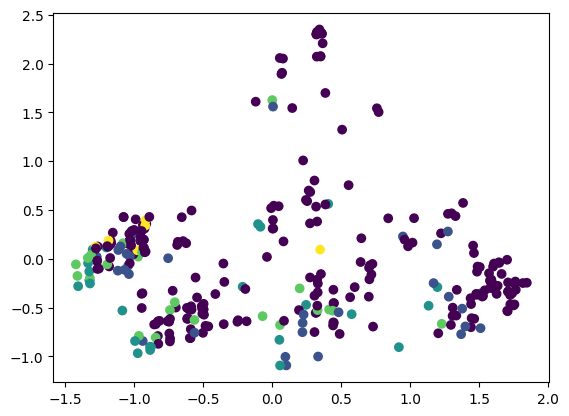

In [39]:
from sklearn.decomposition import PCA


# Convert datetime features to numerical representations
# For example, you can extract numerical features from datetime objects

#df=df.copy().drop(columns=['ReportDate'])
X_train, X_test, y_train, y_test = preprocess_data(df=df.copy())

# Convert X_train and X_test to Pandas DataFrames if they are NumPy arrays
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test)

#Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

#Apply one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

#Set column names for encoded features
X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

#Drop original categorical columns and concat encoded features
X_train = X_train.drop(categorical_cols, axis=1).reset_index(drop=True)
X_train = pd.concat([X_train, X_train_encoded], axis=1)

X_test = X_test.drop(categorical_cols, axis=1).reset_index(drop=True)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Create SVM and Logistic Regression models with specified parameters
svm_model = SVC(kernel='linear', gamma='scale', C=1)
lr_model = LogisticRegression(C=0.001, penalty='none', solver='newton-cg')

# Train both models on the training data
svm_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Evaluate both models on the test data
svm_score = svm_model.score(X_test, y_test)
lr_score = lr_model.score(X_test, y_test)

# Print model scores
print("SVM accuracy:", svm_score)
print("Logistic Regression accuracy:", lr_score)

# Perform PCA on the data
# Choose either X_train or X_test for PCA.
# For this example, we'll use X_train
X = X_train.values  # Extract NumPy array from DataFrame if necessary

# Instantiate PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

from sklearn.decomposition import PCA


# Convert datetime features to numerical representations
# For example, you can extract numerical features from datetime objects

#df=df.copy().drop(columns=['ReportDate'])
X_train, X_test, y_train, y_test = preprocess_data(df=df.copy())

# Convert X_train and X_test to Pandas DataFrames if they are NumPy arrays
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test)

#Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

#Apply one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

#Set column names for encoded features
X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

#Drop original categorical columns and concat encoded features
X_train = X_train.drop(categorical_cols, axis=1).reset_index(drop=True)
X_train = pd.concat([X_train, X_train_encoded], axis=1)

X_test = X_test.drop(categorical_cols, axis=1).reset_index(drop=True)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Create SVM and Logistic Regression models with specified parameters
svm_model = SVC(kernel='linear', gamma='scale', C=1)
lr_model = LogisticRegression(C=0.001, penalty='none', solver='newton-cg')

# Train both models on the training data
svm_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Evaluate both models on the test data
svm_score = svm_model.score(X_test, y_test)
lr_score = lr_model.score(X_test, y_test)

# Print model scores
print("SVM accuracy:", svm_score)
print("Logistic Regression accuracy:", lr_score)

# Perform PCA on the data
# Choose either X_train or X_test for PCA.
# For this example, we'll use X_train
X = X_train.values  # Extract NumPy array from DataFrame if necessary

# Instantiate PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Convert y_train to numerical labels if it's categorical
# Assuming 'y_train' is a Pandas Series with categorical data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)

# Plot the data points in the reduced space
print("Plot the data points in the reduced space")
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train_numeric)
plt.show()